In [46]:
from __future__ import annotations
import sys; sys.path.insert(0, '..')

%load_ext autoreload
%autoreload 2


# python
import os
import ssl
import csv

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import session_info

from pathlib import Path
from inspect import cleandoc

# utils
from utils import Constants
from modules.preprocesing import preprocess

from wordcloud import WordCloud

# text
import re
import spacy
import unidecode
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from sklearn.decomposition import LatentDirichletAllocation

# sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

# stat
from scipy import stats

# statsmodels
from statsmodels.stats.multicomp import pairwise_tukeyhsd


# typings
from pandas import DataFrame as PandasDF
from typing import List, Dict, Union

# setup
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('max_colwidth', None)
# decimals
np.set_printoptions(precision=6)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# cargar el dataset sklearn
if not os.environ.get('CI'):
    ssl._create_default_https_context =\
        ssl._create_unverified_context
          
# rutas absolutas
here: Path = Path.cwd().absolute().parent
data: Path = here / 'data'
poetry_fundation_cleaned: Path = data / 'CleanedPoetryFoundationData.csv'
cv_poetry: Path = data / 'vallejo_poems_en.csv'

In [14]:
setup_load:Dict = dict(
    sep=Constants.PIPE_STR,
    quotechar='"',
    quoting=csv.QUOTE_NONNUMERIC,
    encoding=Constants.ENCODING
)

if not poetry_fundation_cleaned.is_file() or not cv_poetry.is_file():
    raise FileNotFoundError(
        cleandoc(f'''
        El archivo {poetry_fundation_cleaned} no existe.
        Por favor, descargue el archivo desde:
        https://www.kaggle.com/datasets/abhinavwalia95/poetryfoundationorg
        y coloquelo en la carpeta data.
        ''')
    )
    
poetry_df: PandasDF = (
    pd.read_csv(
        str(poetry_fundation_cleaned), 
        **setup_load
    ).dropna(subset=['title'])
)

cv_df: PandasDF = (
        pd.read_csv(
        str(cv_poetry), 
        **setup_load
    )
)

cv_df[['title', 'poem']] = (
        cv_df[['title', 'poem']]
        .apply(lambda col: col.astype(str).apply(preprocess))
    )

poetry_df = poetry_df.loc[~poetry_df.poem.isna(),:]

In [15]:
display(poetry_df.head(3))

,title,poem,poet,tags
0,invis fish,invis fish swim ghost ocean describ wave sand waterworn rock soon fish learn walk human come ashor paint dream die stone later later ocean floor punctuat chevi truck carri dreamer decend go store,joy harjo,"['living', 'time brevity', 'relationships', 'family ancestors', 'nature', 'landscapes pastorals', 'seas', 'rivers', 'streams', 'social commentaries', 'history politics']"
1,not bother earth spirit,not bother earth spirit live work stori oldest stori world delic chang see watch invit coffe warm bread oblig stay listen ordinari stori endur earthquak lightn death love blind beauti stori compel want leav trap stone finger escap,joy harjo,"['religion', 'the spiritual', 'mythology folklore', 'fairytales legends']"
2,hour consid hydrangea,hour consid hydrangea salt sand plant variet question variet diet mother know pound feel like lose lose ye sens possibl beauti grow extern extern beauti beauti occur surfac plant sun darken skin child small beauti obviou beauti hand swell bite spread insect venom small appear feel smash skull floor scream hold lap kitchen floor open freezer press pack frozen clay forehead like cold obviou hydrangea walk push child stroller walk push haul lift have bodi adjunct bodi compos errand weight tender small power imagin feel small weight pound like interf twitch muscl bodi object mother confus middleag mother littl spare flesh feel inch major muscl pull graviti weight child sleep hour think hydrangea let man look stop brush drowsi child littl eye face bare consid mother consid miss subtl power differenti time mass apprehen,simon white,"['living', 'parenthood', 'the body', 'the mind', 'nature', 'trees flowers']"


In [16]:
display(cv_df.head(3))

,title,poem
0,black herald,blow life power not know blow god hatr backlash suffer dam soul not know open dark furrow fierce face strong mayb hors barbar attila black herald death send deep abyss soul christ rever faith destini blasphem gori blow crackl bread burnsup oven door man poor poor turn eye slap shoulder call turn craze eye live dam like pond guilt gaze blow life power not know
1,black stone white stone,shall die pari rainstorm day rememb shall die pari bother doubtless thursday like today autumn shall thursday today thursday line set shoulder evil like today turn head journey way cesar vallejo dead strike hit hard stick hard end rope wit thursday shoulder bone loneli rain road
2,pari octob poem,leav bench away pant great situat action number split leav champ elyse strang alley moon make turn death goe away cradl leav surround peopl cut loo human resembl turn dispatch shadow away remain creat alibi shoe eyelet mud bend elbow button shirt


In [28]:
new_poems_df: PandasDF = pd.concat([
    poetry_df[['title', 'poem']],
    cv_df[['title', 'poem']]
])

In [29]:
# 2. Vectorizar el texto
tfidf = TfidfVectorizer(max_features=5000) # Limitar a 5000 palabras más importantes
tfidf_matrix  = tfidf.fit_transform(new_poems_df.poem)

In [30]:
df_tfidf = pd.DataFrame(
    tfidf_matrix.toarray(), 
    index=new_poems_df.title, 
    columns=tfidf.get_feature_names_out()
)
display(df_tfidf)

abandon  abid  abil  abl  abraham  abroad  absenc  \
title                                                                        
invis fish                   0.0   0.0   0.0  0.0      0.0     0.0     0.0   
not bother earth spirit      0.0   0.0   0.0  0.0      0.0     0.0     0.0   
hour consid hydrangea        0.0   0.0   0.0  0.0      0.0     0.0     0.0   
scar                         0.0   0.0   0.0  0.0      0.0     0.0     0.0   
remain                       0.0   0.0   0.0  0.0      0.0     0.0     0.0   
...                          ...   ...   ...  ...      ...     ...     ...   
fear                         0.0   0.0   0.0  0.0      0.0     0.0     0.0   
black herald                 0.0   0.0   0.0  0.0      0.0     0.0     0.0   
black stone white stone      0.0   0.0   0.0  0.0      0.0     0.0     0.0   
pari octob poem              0.0   0.0   0.0  0.0      0.0     0.0     0.0   
xiii                         0.0   0.0   0.0  0.0      0.0     0.0     0.0   

                         absent  absolut  absorb  abstract  absurd  abund  \
title                                                                       
invis fish                  0.0      0.0     0.0       0.0     0.0    0.0   
not bother earth spirit     0.0      0.0     0.0       0.0     0.0    0.0   
hour consid hydrangea       0.0      0.0     0.0       0.0     0.0    0.0   
scar                        0.0      0.0     0.0       0.0     0.0    0.0   
remain                      0.0      0.0     0.0       0.0     0.0    0.0   
...                         ...      ...     ...       ...     ...    ...   
fear                        0.0      0.0     0.0       0.0     0.0    0.0   
black herald                0.0      0.0     0.0       0.0     0.0    0.0   
black stone white stone     0.0      0.0     0.0       0.0     0.0    0.0   
pari octob poem             0.0      0.0     0.0       0.0     0.0    0.0   
xiii                        0.0      0.0     0.0       0.0     0.0    0.0   

                         abus     abyss  accent  accept  access  accid  \
title                                                                    
invis fish                0.0  0.000000     0.0     0.0     0.0    0.0   
not bother earth spirit   0.0  0.000000     0.0     0.0     0.0    0.0   
hour consid hydrangea     0.0  0.000000     0.0     0.0     0.0    0.0   
scar                      0.0  0.000000     0.0     0.0     0.0    0.0   
remain                    0.0  0.000000     0.0     0.0     0.0    0.0   
...                       ...       ...     ...     ...     ...    ...   
fear                      0.0  0.000000     0.0     0.0     0.0    0.0   
black herald              0.0  0.161126     0.0     0.0     0.0    0.0   
black stone white stone   0.0  0.000000     0.0     0.0     0.0    0.0   
pari octob poem           0.0  0.000000     0.0     0.0     0.0    0.0   
xiii                      0.0  0.000000     0.0     0.0     0.0    0.0   

                         accident  accompani  accomplish  accord  account  \
title                                                                       
invis fish                    0.0        0.0         0.0     0.0      0.0   
not bother earth spirit       0.0        0.0         0.0     0.0      0.0   
hour consid hydrangea         0.0        0.0         0.0     0.0      0.0   
scar                          0.0        0.0         0.0     0.0      0.0   
remain                        0.0        0.0         0.0     0.0      0.0   
...                           ...        ...         ...     ...      ...   
fear                          0.0        0.0         0.0     0.0      0.0   
black herald                  0.0        0.0         0.0     0.0      0.0   
black stone white stone       0.0        0.0         0.0     0.0      0.0   
pari octob poem               0.0        0.0         0.0     0.0      0.0   
xiii                          0.0        0.0         0.0     0.0      0.0   

                         accumul  accur  ac

In [34]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim

array([[1.      , 0.017821, 0.046964, ..., 0.017969, 0.021071, 0.010993],
       [0.017821, 1.      , 0.030733, ..., 0.0316  , 0.040423, 0.018561],
       [0.046964, 0.030733, 1.      , ..., 0.007552, 0.      , 0.018709],
       ...,
       [0.017969, 0.0316  , 0.007552, ..., 1.      , 0.012857, 0.01698 ],
       [0.021071, 0.040423, 0.      , ..., 0.012857, 1.      , 0.023382],
       [0.010993, 0.018561, 0.018709, ..., 0.01698 , 0.023382, 1.      ]])

In [44]:
def recomendador(title, cosine_sim=cosine_sim, df=new_poems_df):
    
    #Paso 2
    df = df.reset_index()
    indices = pd.Series(df.index, index=df.title).drop_duplicates()
    #Paso 3
    idx = indices[title]

    #Paso 4
    sim_scores = list(enumerate(cosine_sim[idx]))

    #Paso 5
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    #Paso 6
    sim_scores = sim_scores[1:11]

    _indices = [i[0] for i in sim_scores]

    #Paso 7
    return pd.DataFrame(df.title.iloc[_indices])

In [45]:
display(recomendador('black herald'))

,title
623,aim song
3259,way wind blow
1822,keumganggul diamond cave
9313,ballad salvat armi
6145,fortuna
5875,american histori
11911,princess splendour fall castl wall
1644,curs name
5126,sea
3336,book dead dam


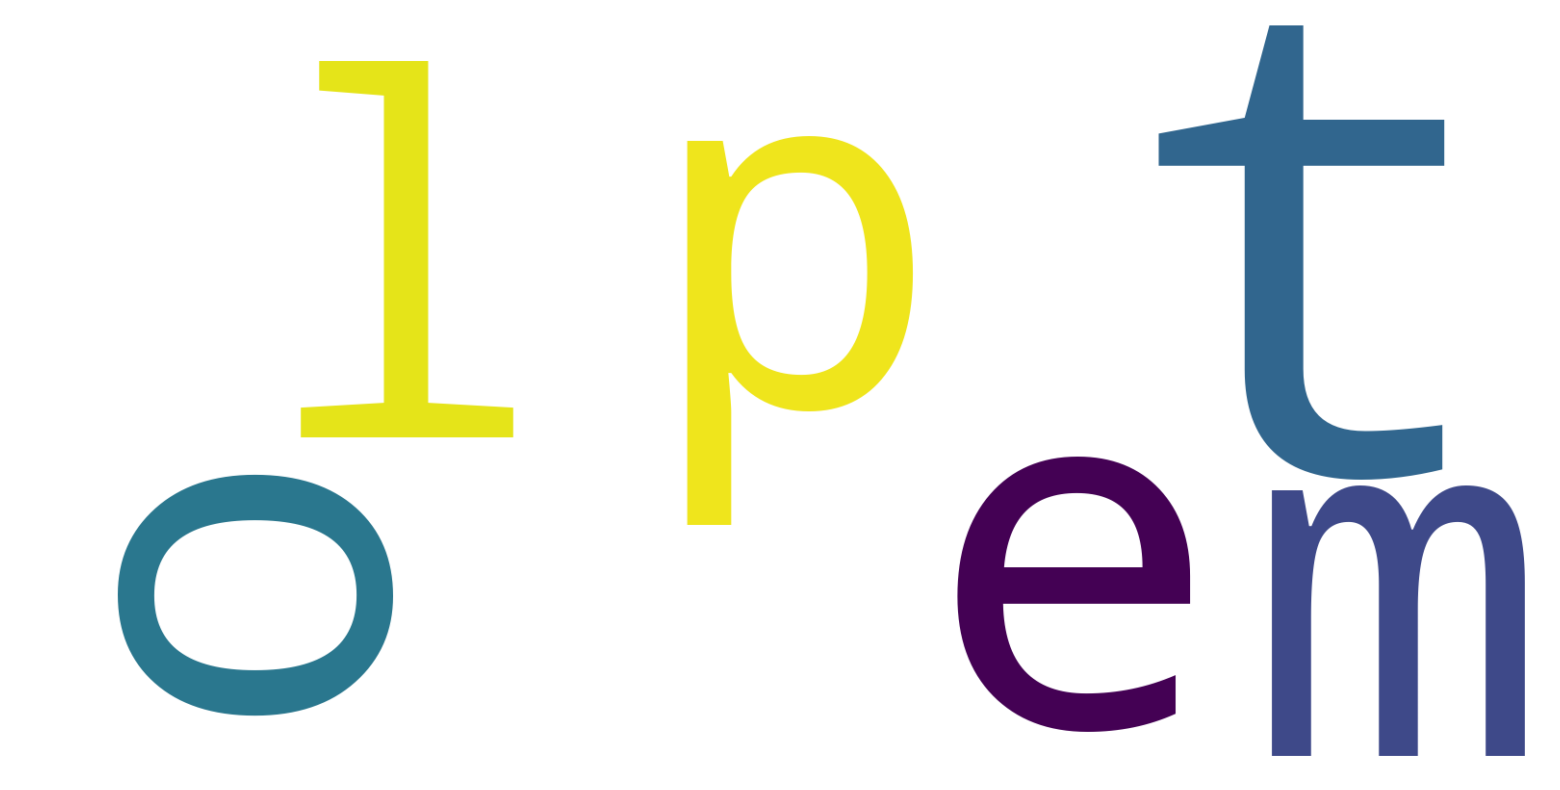

In [56]:
#ponemos en un vector los poemas recomendadas
poems = new_poems_df[new_poems_df.title.isin(recomendador('black herald'))]

#Limpiamos el texto
text = " ".join(poems)
text = preprocess(text)
text = ' '.join(text)
# lematizar

# Armamos la nube de palabras
wordcloud = WordCloud(width = 1600, height = 800, 
    background_color = "white").generate(text)
plt.figure(figsize = (20, 10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()